---
title: Applying logistic regression in Python
---

...from lessons learned from Andrew Ng's [ML course](https://www.youtube.com/watch?v=-la3q9d7AKQ). Like other assignments of the course, the logistic regression assignment used MATLAB. Here, I also translate MATLAB code into Python. I apply the mathematical concepts and the Python code to a datset I evaluated in another [project](https://benslack19.github.io/projects/predicting_states_sc_analysis/#supervised-machine-learning). Check out the project link for more context to this post.

## Import packages and data from project notebook

In [10]:
# Import packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

I followed this StackOverflow [post](https://stackoverflow.com/questions/31621414/share-data-between-ipython-notebooks) to store and transfer the data from my [activation state project](https://benslack19.github.io/projects/predicting_states_sc_analysis/#supervised-machine-learning) into this Jupyter notebook and post.

In [3]:
# Import data
%store -r X   # This is the entire data  
%store -r y   # This is the activation state label.

In [29]:
# Narrowed the dataset down to features (genes)
# that were already known to contribute to group
# separation.
X = X.loc[:,['Arc', 'Plk2']]

## Logistic regression functions

I use the naming conventions of the Ng course. The logistic regression model is such that we want the hypothesis to be within the bounds 0 and 1.

$ 0 \leq h_{\theta}(x) \leq 1$

If $ h_{\theta}(x) = g(\theta^Tx) $ and $ g(z) = \frac{1}{1 + \exp(-z)}\ $
then

$ h_{\theta}(x) = \frac{1}{1 + exp(-\theta^Tx)} $

The objective will be to determine the parameters $\theta$.

## Plotting
We start the exercise by first plotting the top two features of the data. Blue is the negative class, red is the positive class.

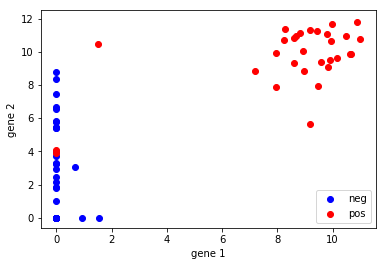

In [59]:
# Matplotlib plotting syntax isdifferent from MATLAB
f, (ax1) = plt.subplots(1,1);
mask = y==0;
ax1.scatter(x=X.loc[mask,'Arc'], y=X.loc[mask,'Plk2'], color='blue', label='neg');
mask = y==1;
ax1.scatter(x=X.loc[mask,'Arc'], y=X.loc[mask,'Plk2'], color='red', label='pos');
ax1.set_xlabel('gene 1');
ax1.set_ylabel('gene 2');
ax1.legend();

## Compute Cost and Gradient

These were the directions in the MATLAB code of the ML course assignment:
"In this part of the exercise, you will implement the cost and gradient
for logistic regression. You need to complete the code in costFunction.m."

I'll make each function a separate Jupyter cell.

In [32]:
# Sigmoid function
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))

In [33]:
# Cost function
def costFunction(theta, X, y):
    # Initialize some useful values
    m = len(y);
    J = 0;
    grad = np.zeros(theta.shape)
    
    # -- code exercise from class (MATLAB code commented out)--- 
    # h = sigmoid(X*theta);
    h = sigmoid(np.dot(X, theta)).flatten()  # flatten needed from testing
    # J = 1/m*((-y'*log(h))-(1-y)'*log(1-h)); 
    step1 = np.dot(y.T, np.log(h))
    step2 = np.dot((1-y).T, np.log(1-h))
    J = (1/m)*(-step1-step2);
    # grad = 1/m*(X'*(h-y));
    grad = (1/m)*(np.dot(X.T,(h-y)));
    return (J, grad)

In [34]:
# Setup the data matrix appropriately, and add ones for the intercept term
# [m, n] = size(X);
(m, n) = X.shape;

# Add intercept term to x and X_test
# X = [ones(m, 1) X];
X.insert(loc=0, column='x0', value=np.ones((m, 1)))

# Initialize fitting parameters
# initial_theta = zeros(n + 1, 1);
initial_theta = np.zeros((n + 1, 1));

In [35]:
# Compute and display initial cost and gradient
# [cost, grad] = costFunction(initial_theta, X, y);
(cost, grad) = costFunction(initial_theta, X, y);
print('Cost at initial theta (zeros): ', cost);
print('Gradient at test theta: \n', grad);

Cost at initial theta (zeros):  0.69314718056
Gradient at test theta: 
 [ 0.0890411  -1.71746865 -1.32378626]


## Optimizing using fmin_tnc for Python (fminunc in MATLAB)

Course directions say: "In this exercise, you will use a built-in function (fminunc) to find the optimal parameters theta."

Here's where things got tricky for me. I initially wasn't sure what optimization function to use. I was both informed and confused by what I found online, partly because sometimes cost and gradient were calculated in separate functions. In the MATLAB course, the cost and gradient were returned in the same function (```costFunction```) so I did the same. This is what course notes said about using ```fminunc```:

*"In this code snippet, we first defined the options to be used with fminunc. Specifically, we set the GradObj option to on, which tells ```fminunc``` that our function returns both the cost and the gradient. This allows fminunc to use the gradient when minimizing the function."*

The Python minimizatioon function I settled on using was [```fmin_tnc```](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fmin_tnc.html) which I chose from looking at [this post](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/). In that example, the author had gradient as a separate function. From looking at the documentation, it looks like ```fmin_tnc``` can handle the optimized function either with or without the gradient being returned. If it's not returned, one has to specify the gradient function in the ```fprime``` parameter of ```fmin_tnc```.

In [37]:
import scipy.optimize as opt  

In [38]:
# The x0 parameter is the initial guess so I will set that to inital_theta.
result = opt.fmin_tnc(func=costFunction, x0=initial_theta, args=(X, y))

In [39]:
print('Thetas found by fmin_tnc function: ', result[0]);

Thetas found by fmin_tnc function:  [-4.22742279  1.44227184  0.32931704]


In [40]:
optimal_theta = result[0]
(cost, grad) = costFunction(optimal_theta, X, y)
print('Cost at theta found by scipy fmin_tnc: ', cost);

Cost at theta found by scipy fmin_tnc:  0.114571357011


## Plotting the decision boundary

In the course, the MATLAB function was given to us as ```plotDecisionBoundary.m```. Initially, my strategy was going to do a nearly line-for-line translation of the MATLAB code to Python syntax, but since the plotting is quite different, I just ended up testing code and coming up with my own function.

### Determine the decision boundary linear equation.

From the lectures:
$ h_{\theta}(x) = g(\theta^Tx) \geq 0.5$ when $\theta^Tx \geq 0$.

In the case of two features:

$ h_{\theta}(x) = g(\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2})$

Therefore: $\theta_{0} + \theta_{1}x_{1} + \theta_{2}x_{2} \geq 0$

We can re-arrange to solve for the linear equation: $ x_{2} = \frac{-\theta_{1}x_{1} - \theta_{0}}{\theta_{2}}\ $




In [41]:
# Calculations for the decision boundary line equation.
slope = -optimal_theta[1]/optimal_theta[2]
yint = -optimal_theta[0]/optimal_theta[2]
print('slope: ', slope)
print('y-intercept: ', yint)

slope:  -4.37958460074
y-intercept:  12.8369391073


The equation of the line is therefore:
$ x_{2} = -4.380x_{1} + 12.837 $

Looking at the plot of data above, this seems like a reasonable equation for the decision boundary.

###  ```plotDecisionBoundary``` function

In [55]:
def plotDecisionBoundary(theta, X, y):
    
    # Plot data
    f, (ax1) = plt.subplots(1,1);
    mask = y==0;
    ax1.scatter(x=X.loc[mask,'Arc'], y=X.loc[mask,'Plk2'], color='blue', label='neg');
    mask = y==1;
    ax1.scatter(x=X.loc[mask,'Arc'], y=X.loc[mask,'Plk2'], color='red', label='pos');
    ax1.set_xlabel('gene 1');
    ax1.set_ylabel('gene 2');

    # Calculations for the decision boundary line equation
    slope = -theta[1]/theta[2]
    yint = -theta[0]/theta[2]

    # Plot the decision boundary
    f_line = lambda x: slope*x + yint;

    # Use the min and max of x values
    x = np.array([min(X.loc[:,'Arc']),max(X.loc[:,'Arc'])]);
    ax1.plot(x,f_line(x), c="orange", label="decision boundary");
    ax1.set_ylim(bottom=-1)
    ax1.legend();

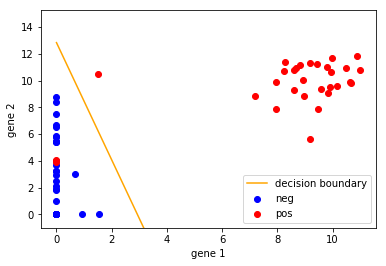

In [56]:
plotDecisionBoundary(optimal_theta, X, y)

This seems like a reasonable decision boundary.

## Prediction and Accuracies

The ML course instructed us to create a predict function and then use that to compute the accuracy of the predicted classification.

In [57]:
# Prediction function
def predict(theta, X):
    h = sigmoid(np.dot(X, theta)).flatten()
    p = h >= 0.5
    return p

In [58]:
# Compute accuracy on our training set
p = predict(optimal_theta, X);
print('Train Accuracy: ', np.mean(p == y) * 100);

Train Accuracy:  97.2602739726


## Conclusion

Scikit-learn is an amazing package. It is not practical to do machine learning in Python without it. Even if you knew all the math for implementing a function, you would not write it out for every project as I did in the above example. However, by writing out the steps from the Machine Learning course, it helped re-inforce those lessons in addition to learning more about Python optimization functions.

Others had translated the MATLAB code to Python for the course assignment. Check out those Python implementations I found ([here](http://aimotion.blogspot.com/2011/11/machine-learning-with-python-logistic.html), [here](http://nbviewer.jupyter.org/github/tfolkman/learningwithdata/blob/master/Logistic%20Gradient%20Descent.ipynb), and [here](http://www.johnwittenauer.net/machine-learning-exercises-in-python-part-3/)). In this post, I did something similar except with a slice of a personal project dataset.